In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_coag_baseline'] == 0.0]

    design_matrix['sofa_coag_diff2'] = design_matrix['sofa_coag_day2'] - design_matrix['sofa_coag_baseline']
    design_matrix['sofa_coag_diff3'] = design_matrix['sofa_coag_day3'] - design_matrix['sofa_coag_baseline']
    design_matrix['sofa_coag_diff1'] = design_matrix['sofa_coag_day1'] - design_matrix['sofa_coag_baseline']

    design_matrix['max_coag_diff'] = np.max(
        design_matrix[
            [
                'sofa_coag_day1', 
                'sofa_coag_day2', 
                'sofa_coag_day3'
            ]
        ], 
        axis=1
    )

    design_matrix['group'] = np.where(
        design_matrix['max_coag_diff'] > 0, 2, 1
    )

    # design_matrix = design_matrix[
    #     (design_matrix['trc_emergency_department'] < 150) |
    #     (design_matrix['trc_emergency_department'] > 200)
    # ].copy()


    # design_matrix['group'] = np.where(
    #     design_matrix['trc_emergency_department'] < 150, 2, 1
    # )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     

# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
trc_cols = []

for col in design_matrix_otrain.columns:

    if "trc" in col or "plat" in col:

        print(col)
        trc_cols.append(col)

trc_emergency_department


In [7]:
design_matrix_otrain[trc_cols]

,trc_emergency_department
0,141.0
1,386.0
2,279.0
3,146.0
4,255.0
...,...
675,652.0
676,314.0
677,441.0
678,258.0


In [8]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

/tmp/ipykernel_1034874/3944249577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['sofa_coag_diff2'] = design_matrix['sofa_coag_day2'] - design_matrix['sofa_coag_baseline']
/tmp/ipykernel_1034874/3944249577.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['sofa_coag_diff3'] = design_matrix['sofa_coag_day3'] - design_matrix['sofa_coag_baseline']
/tmp/ipykernel_1034874/3944249577.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<Axes: xlabel='trc_emergency_department', ylabel='Count'>

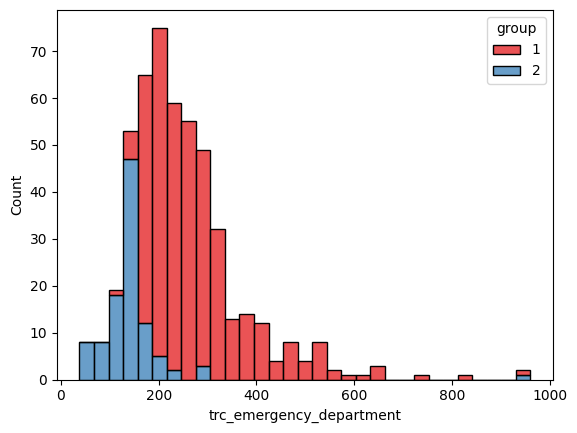

In [9]:
sns.histplot(
    design_matrix_train,
    x="trc_emergency_department",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [10]:
design_matrix_train['group'].value_counts()

group
1    526
2    116
Name: count, dtype: int64

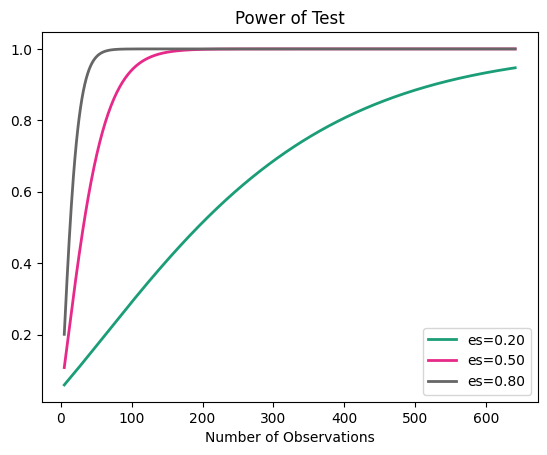

In [11]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [12]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [13]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [14]:
quant_matrix_train.write("de_results/coag_de_proteins.tsv")

In [15]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

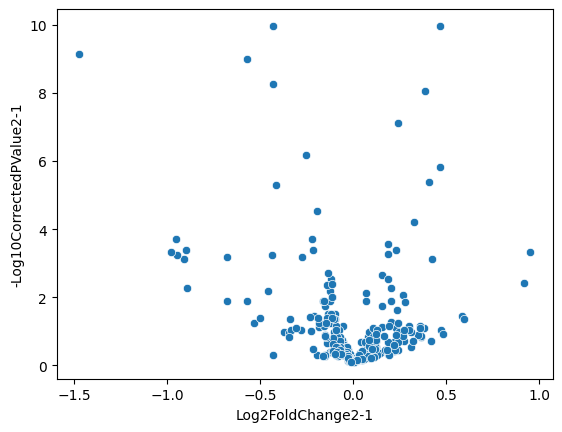

In [16]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [17]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [18]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [19]:
protein_columns = training_data.columns.to_list()

In [20]:
len(protein_columns)

287

In [21]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf,
#     random_state=42
# )

In [23]:
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

label_issues = find_label_issues(
    labels=y.values.ravel(),
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'  # Ranks by likelihood of being mislabeled
)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
mask = np.ones(len(y.values.ravel()), dtype=bool)

mask[label_issues] = False

In [25]:
X = X.iloc[mask, :].copy()
y = y.iloc[mask, :].copy()

In [26]:
y['label'].value_counts()

label
0    446
1     63
Name: count, dtype: int64

In [27]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.570627802690583, 1: 4.0396825396825395}

In [28]:
len(protein_columns)

287

In [29]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


In [30]:
selected_proteins

['PLF4_HUMAN',
 'ICAM1_HUMAN',
 'FCG3A_HUMAN',
 'ITB3_HUMAN',
 'CXCL7_HUMAN',
 'CBPB2_HUMAN',
 'VCAM1_HUMAN',
 'HEP2_HUMAN',
 'ALDOB_HUMAN',
 'TSP1_HUMAN',
 'BGH3_HUMAN',
 'FUCO_HUMAN',
 'ITA2B_HUMAN',
 'A1AT_HUMAN',
 'C163A_HUMAN',
 'PROC_HUMAN',
 'TPM4_HUMAN',
 'VWF_HUMAN',
 'CD44_HUMAN',
 'CO6_HUMAN',
 'FLNA_HUMAN',
 'TRFE_HUMAN',
 'PLTP_HUMAN',
 'PDLI1_HUMAN',
 'SAMP_HUMAN',
 'FCGBP_HUMAN',
 'SPP24_HUMAN',
 'K1C10_HUMAN',
 'CAMP_HUMAN',
 'ACTN1_HUMAN',
 'CATD_HUMAN',
 'TPM3_HUMAN',
 'FA7_HUMAN',
 'CSPG2_HUMAN',
 'HGFL_HUMAN',
 'VSIG4_HUMAN',
 'URP2_HUMAN',
 'COL10_HUMAN',
 'TIMP1_HUMAN',
 'NCHL1_HUMAN',
 'FA12_HUMAN',
 'TBB1_HUMAN',
 'LAMP2_HUMAN',
 'THRB_HUMAN',
 'FHR4_HUMAN',
 'MYL6_HUMAN',
 'K22E_HUMAN',
 'CATB_HUMAN',
 'SAA4_HUMAN',
 'ALBU_HUMAN']

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7619047619047619, 0.5865102639296188, 0.8997679545190858, 0.840570556174583)

In [33]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [34]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [35]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [36]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
4,CXCL7_HUMAN,1.000000,1.0,0.775594,2.0,1.000000,1.0,0.828077,2.0,0.965737,...,1.000000,1.0,0.889024,4.0,0.817577,0.888299,0.213240,4.40,2.0,5.994947
5,CBPB2_HUMAN,0.780162,3.0,0.703280,4.0,0.461837,10.0,0.526230,6.0,0.504919,...,0.511796,8.0,0.659039,10.0,0.612676,0.559417,0.260627,10.57,7.0,10.534460
9,TSP1_HUMAN,0.673227,5.0,0.522935,10.0,0.365282,18.0,0.138685,34.0,0.528439,...,0.720344,4.0,0.973406,2.0,0.556164,0.563775,0.266705,12.55,8.0,11.757976
0,PLF4_HUMAN,0.881395,2.0,0.208851,29.0,0.395546,16.0,0.635934,5.0,0.926624,...,0.648551,6.0,0.404703,16.0,0.535561,0.524351,0.224963,12.46,9.0,10.662329
17,VWF_HUMAN,0.091632,39.0,0.602551,6.0,0.645404,5.0,1.000000,1.0,0.787912,...,0.823656,3.0,0.760410,6.0,0.521828,0.467570,0.256644,14.00,11.0,11.658439
21,TRFE_HUMAN,0.211082,31.0,0.574409,9.0,0.573189,6.0,0.378841,11.0,0.607862,...,0.012719,50.0,0.003320,50.0,0.479543,0.481215,0.259709,15.93,11.0,12.898403
3,ITB3_HUMAN,0.019369,49.0,0.589552,8.0,0.696858,4.0,0.746750,3.0,0.879411,...,0.033077,47.0,0.567614,12.0,0.401865,0.368900,0.284002,21.45,16.5,15.876655
25,FCGBP_HUMAN,0.208053,32.0,0.271813,23.0,0.522123,7.0,0.701763,4.0,0.462911,...,0.286252,21.0,0.291403,23.0,0.386541,0.365679,0.214222,20.08,18.0,12.865803
15,PROC_HUMAN,0.256052,29.0,0.275791,21.0,0.151290,34.0,0.307560,16.0,0.888544,...,0.333938,18.0,0.082023,40.0,0.383144,0.345956,0.244300,20.98,17.0,13.623346
37,COL10_HUMAN,0.120926,36.0,0.758665,3.0,0.750981,3.0,0.164000,32.0,0.356793,...,0.247642,26.0,0.684263,9.0,0.380664,0.357579,0.222536,20.67,18.0,12.936562


In [37]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [38]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [39]:
selected_features = selected_proteins[:10]

In [40]:
for feature in selected_features:

    print(feature)

CXCL7_HUMAN
CBPB2_HUMAN
TSP1_HUMAN
PLF4_HUMAN
VWF_HUMAN
TRFE_HUMAN
ITB3_HUMAN
FCGBP_HUMAN
PROC_HUMAN
COL10_HUMAN


In [41]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [42]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.8095238095238094,
 0.49595959595959593,
 0.8723749854971574,
 0.8453870937092414)

In [43]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.5873015873015873, 0.6613003095975233, 0.911567467223576, 0.7723375340825006)

In [44]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [45]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [46]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [47]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
4,VWF_HUMAN,0.880904,3.0,0.663121,3.0,1.000000,1.0,1.000000,1.0,0.857054,...,1.000000,1.0,1.000000,1.0,0.898554,1.000000,0.143984,1.85,1.0,1.095215
0,CXCL7_HUMAN,0.720461,5.0,1.000000,1.0,0.957292,2.0,0.599914,2.0,1.000000,...,0.941226,2.0,0.498809,6.0,0.773995,0.823828,0.234797,3.23,2.0,2.477597
7,FCGBP_HUMAN,0.913555,2.0,0.427406,7.0,0.834956,3.0,0.538972,3.0,0.733928,...,0.677782,3.0,0.593050,4.0,0.655475,0.639319,0.191075,4.23,4.0,1.942897
6,ITB3_HUMAN,0.660925,6.0,0.654293,4.0,0.703889,5.0,0.534410,4.0,0.596946,...,0.357074,6.0,0.759696,3.0,0.591921,0.591817,0.226391,5.02,5.0,2.300549
1,CBPB2_HUMAN,0.822412,4.0,0.881861,2.0,0.587374,6.0,0.422818,5.0,0.022687,...,0.286564,7.0,0.874845,2.0,0.585552,0.560671,0.215205,5.09,5.0,2.353141
5,TRFE_HUMAN,0.515486,9.0,0.493236,6.0,0.779641,4.0,0.300884,7.0,0.378268,...,0.182957,10.0,0.186413,10.0,0.493250,0.498157,0.194967,6.14,6.0,2.215738
8,PROC_HUMAN,0.565667,7.0,0.245524,9.0,0.304659,8.0,0.188819,8.0,0.580711,...,0.421064,5.0,0.206794,9.0,0.427906,0.440315,0.183980,6.94,7.0,1.916541
3,PLF4_HUMAN,1.000000,1.0,0.189311,10.0,0.303118,9.0,0.304393,6.0,0.670534,...,0.237371,8.0,0.336447,8.0,0.422287,0.398737,0.241447,7.06,8.0,2.658396
2,TSP1_HUMAN,0.526218,8.0,0.355822,8.0,0.019356,10.0,0.162745,9.0,0.215736,...,0.589003,4.0,0.591039,5.0,0.410838,0.415736,0.232570,6.99,7.0,2.337637
9,COL10_HUMAN,0.152905,10.0,0.510329,5.0,0.464963,7.0,0.004947,10.0,0.233654,...,0.236166,9.0,0.436521,7.0,0.287745,0.254639,0.179650,8.45,9.0,1.892969


In [48]:
final_protein_importances.to_csv(
    "feature_importances/coag_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [49]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [50]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [51]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [52]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [53]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [54]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [55]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

# lr_clf = BaggingClassifier(
#     estimator=lr_clf,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)


In [56]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [57]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [58]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.5111111111111111,
 0.41420118343195267,
 0.37777777777777777,
 0.3150684931506849,
 0.38509316770186336,
 0.27450980392156865,
 0.4433497536945813,
 0.42696629213483145)

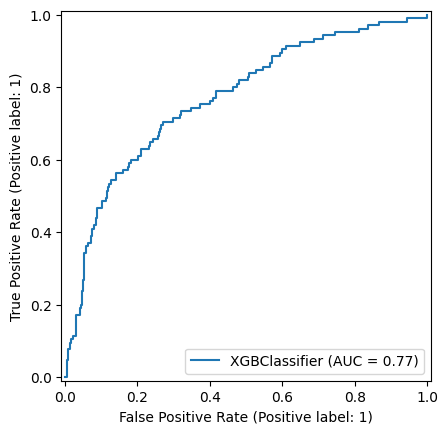

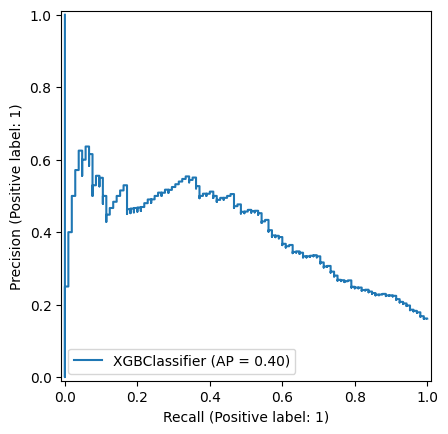

In [59]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    xgb_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    xgb_clf, X_test[selected_features], y_test.values.ravel()
)



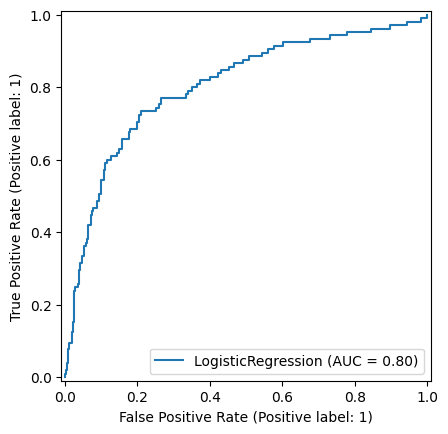

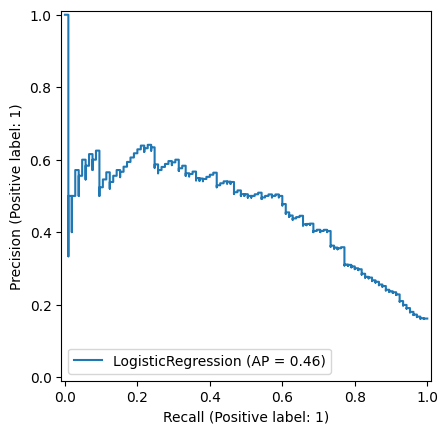

In [60]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [61]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [62]:
roc_df.to_csv(
    "roc/coag.tsv",
    sep="\t"
)

# Probability Prediction

In [63]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [64]:
predict_data = predict_data[protein_columns].copy()

In [65]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [66]:
predict_data['coag_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [67]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['coag_probability']
).reset_index()

In [68]:
predict_data[['coag_probability']].to_csv(
    "predictions_test/coag.tsv",
    sep="\t"
)

<Axes: xlabel='coag_probability', ylabel='Count'>

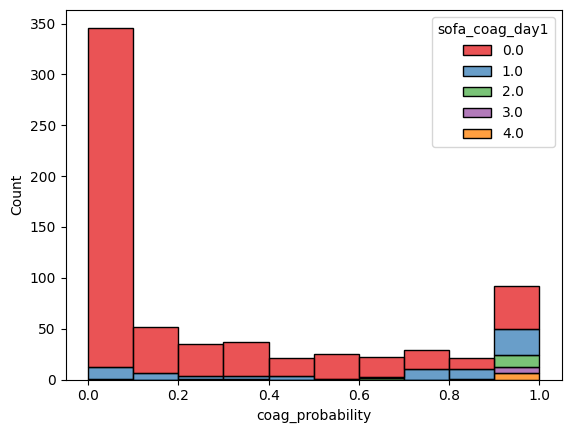

In [69]:
sns.histplot(
    data=design_matrix_test,
    x="coag_probability",
    hue="sofa_coag_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack",
    bins=10
)

In [70]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [71]:
val_data = val_data[protein_columns].copy()

In [72]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [73]:
val_data['coag_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [74]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['coag_probability']
).reset_index()

In [75]:
val_data[['coag_probability']].to_csv(
    "predictions_val/coag.tsv",
    sep="\t"
)

<Axes: xlabel='coag_probability', ylabel='Count'>

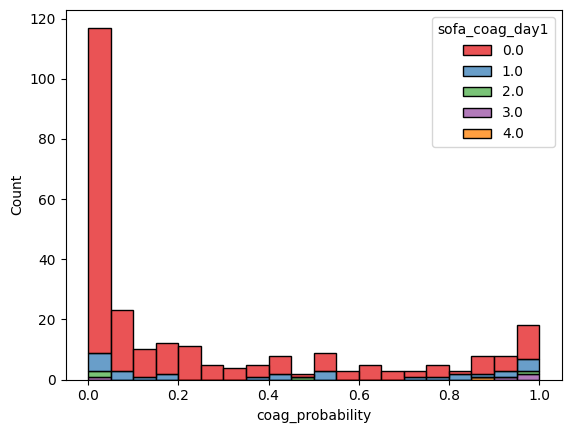

In [76]:
sns.histplot(
    data=design_matrix_val,
    x="coag_probability",
    hue="sofa_coag_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [77]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [78]:
hero_data = hero_data[protein_columns].copy()

In [79]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [80]:
hero_data['coag_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [81]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['coag_probability']
).reset_index()

In [82]:
hero_data[['coag_probability']].to_csv(
    "predictions_external/coag.tsv",
    sep="\t"
)

<Axes: xlabel='coag_probability', ylabel='Count'>

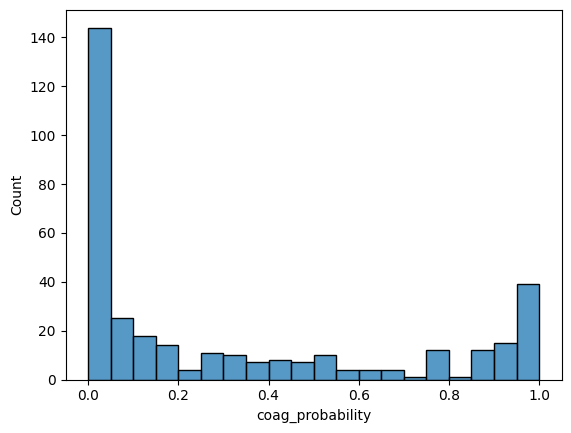

In [83]:
sns.histplot(
    data=hero_data,
    x="coag_probability",
    #hue="sofa_coag_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [84]:
from joblib import dump


with open("models/coag_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/coag_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
